In [1]:
def longest_common_prefix(s1, s2):
    i = 0
    while s1[i] == s2[i] and i < len(s1) and i < len(s2):
        i += 1
    return s1[:i]

In [2]:
longest_common_prefix("ACCATGT", "ACCAGAC")

'ACCA'

In [3]:
def match(s1, s2):
    return s1 == s2

In [4]:
match("AGG", "AGTG")

False

In [5]:
def reverse_complement(s):
    s = s.upper()
    bases = {"A": "T", "G":"C", "T":"A", "C":"G", "N":"N"}
    return "".join([bases[i] for i in s])[::-1]

In [6]:
reverse_complement("Agtc")

'GACT'

In [7]:
def read_genome(filename):
    f = open(filename, "r")
    genome = f.read().split("\n")[1:]
    f.close()
    return "".join(genome)

In [8]:
genome = read_genome("lambda_virus.fa")

In [9]:
print(genome[:100])

GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACC


In [10]:
len(genome)

48502

In [11]:
counts = {"A":0, "C":0, "G":0, "T":0}
for base in genome:
    counts[base] += 1
print(counts)

{'A': 12334, 'C': 11362, 'G': 12820, 'T': 11986}


In [12]:
# Same thing:
import collections
collections.Counter(genome)

Counter({'G': 12820, 'A': 12334, 'T': 11986, 'C': 11362})

In [13]:
def read_fastq(filename):
    with open(filename, 'r') as f:
        content = f.read().rstrip("\n").split("\n")
        seqs = [content[i] for i in range(len(content)) if i%4 == 1]
        quals = [content[i] for i in range(len(content)) if i%4 == 3]
    return seqs, quals

In [14]:
seqs, quals = read_fastq("SRR835775_1.first1000.fastq")

In [15]:
print(len(quals[0]))
print(len(quals))

100
1000


In [16]:
def phred_to_q(qual):
    return ord(qual)-33

In [17]:
def create_hist(quals):
    hist = [0]*50 # highest quality score is 41
    for qual in quals:
        for char in qual:
            q = phred_to_q(char)
            hist[q] += 1
    return hist

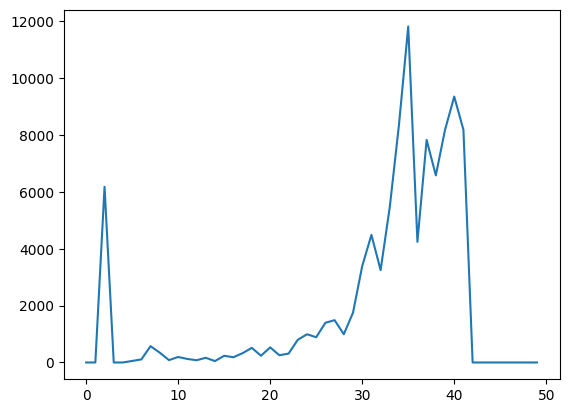

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
h = create_hist(quals)
plt.plot(range(len(h)), h)
plt.show()

In [19]:
def find_gc_by_pos(reads):
    gc = [0]*100
    total = [0]*100
    for read in reads:
        for i in range(100):
            if read[i] in ["C", "G"]:
                gc[i] += 1
            total[i]+= 1
    for i in range(100):
        gc[i] /= float(total[i])
    return gc

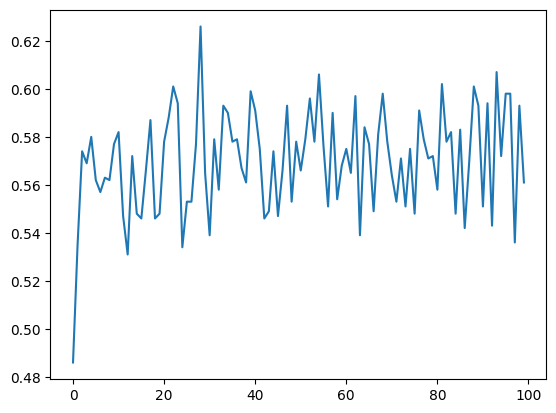

In [20]:
gc = find_gc_by_pos(seqs)
plt.plot(range(len(gc)), gc) # random fluctuations, bbut consistenly higher than 0.5. Human genome has GC content > 0.5
plt.show()

In [21]:
count = collections.Counter()
for seq in seqs:
    count.update(seq)
print(count)

Counter({'G': 28742, 'C': 28272, 'T': 21836, 'A': 21132, 'N': 18})


## Exact Matching

Given some text *T*, at what offset (i.e. index) does pattern *P* occur?

The Python function `find()` can do this easily.

In [22]:
t = 'It was the best of times, it was the blurst of times.'
t.find('blurst')

37

But let's implement this ourselves.

In [23]:
def naive_match(text, pattern):
    occurrences = []
    k = len(pattern)
    for i in range(len(text)-k+1):
        if text[i:i+k] == pattern:
            occurrences.append(i)
    return occurrences

In [24]:
naive_match(t, 'blurst')

[37]

In [88]:
p = 'needle'
t = 'needle need noodle needle'

In [89]:
def naive(p, t):
    occurrences = []
    num_alignments = 0
    num_char = 0
    for i in range(len(t) - len(p) + 1):
        match = True
        for j in range(len(p)):
            num_char += 1
            if t[i+j] != p[j]:
                match = False
                break
        if match:
            occurrences.append(i)
        num_alignments += 1
    return occurrences, num_alignments, num_char

In [90]:
naive(p, t)

([0, 19], 20, 35)

### Practical: Matching artificial reads

Let's read in the genome of an artificial organism.

In [26]:
genome = read_genome("phix.fa")

In [27]:
print(genome[:100])

GAGTTTTATCGCTTCCATGACGCAGAAGTTAACACTTTCGGATATTTCTGATGAGTCGAAAAATTATCTTGATAAAGCAGGAATTACTACTGCTTGTTTA


If we randomly generate some *k*-mers from this genome, we should be able to find them again.

In [28]:
import random
def generate_reads(genome, num_reads, k):
    reads = []
    for n in range(num_reads):
        i = random.randint(0, len(genome)-k+1)
        reads.append(genome[i:i+k])
    return reads

In [29]:
reads = generate_reads(genome, 100, 100)
matched = [i for i in reads if len(naive_match(genome, i)) != 0]
len(matched)

100

But, given "real" DNA sequencing reads, the results aren't so great.

In [30]:
reads, quals = read_fastq("ERR266411_1.first1000.fastq")

In [31]:
num_matched = 0
n = 0
for read in seqs:
    matches = naive_match(genome, read)
    n += 1
    if len(matches) > 0:
        num_matched += 1
print(f'{num_matched} out of {n} reads matched the genome')

0 out of 1000 reads matched the genome


Sequencers have errors, and individual genomes have differences from the reference genome.

### Homework: Strand-Aware Naive Matching

In [32]:
def strand_aware_naive_match(text, pattern):
    occurrences = []
    k = len(pattern)
    rc = reverse_complement(pattern)
    for i in range(len(text)-k+1):
        if text[i:i+k] == pattern:
            occurrences.append(i)
        if text[i:i+k] == rc:
            occurrences.append(i)
    return set(occurrences)

In [33]:
text = 'AAAAAAAAAACCCAAAAAAAAAAGGGAAAAAAAAAA'
pattern = 'CCC'
strand_aware_naive_match(text, pattern)

{10, 23}

In [34]:
lambda_genome = read_genome('lambda_virus.fa')

In [35]:
strand_aware_naive_match(lambda_genome, 'AGTCGA')


{450, 1908, 2472, 18005, 23320, 33657, 41927, 44806, 45369}

### Homework: Approximate Naive Matching (allowing *n* mismatches)

In [36]:
def hamming_dist(p1, p2):
    dist = 0
    for i in range(len(p1)):
        if p1[i] != p2[i]:
            dist += 1
    return dist
    
def approximate_naive_match(text, pattern, n):
    occurrences = []
    k = len(pattern)
    for i in range(len(text)-k+1):
        if text[i:i+k] == pattern:
            occurrences.append(i)
        elif hamming_dist(text[i:i+k], pattern) <= n:
            occurrences.append(i)
    return occurrences

In [37]:
min(approximate_naive_match(lambda_genome, "AGGAGGTT", 2))

49

## Homework: Identifying Bad Sequencing Cycle

In [38]:
seqs, quals = read_fastq("ERR037900_1.first1000.fastq")

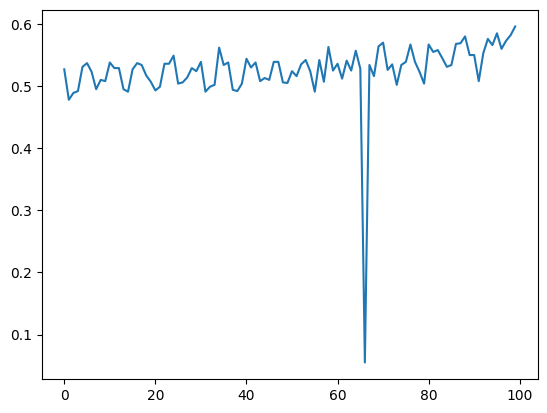

In [39]:
gc = find_gc_by_pos(seqs)
plt.plot(range(len(gc)), gc)
plt.show()

In [40]:
gc_min = min(gc)
print(gc.index(gc_min))

66


## Boyer-Moore Algorithm

* **Given**: *Text* and *Pattern*.
* **Return**: *Positions* in *Text* that matches *Pattern*.

In [41]:
text = "ANPANMAN"
p = "PAN"

## *k*-mer Index

In [42]:
import bisect

In [43]:
class Index(object):
    def __init__(self, text, k):
        self.k = k
        self.index = [(text[i:i+k], i) for i in range(len(text)-k+1)] # list of tuples
        self.index.sort() # sort for binary search

    def query(self, pattern): 
        kmer = pattern[:self.k] # get the first k-mer from pattern
        # return index of the first occurrence of (kmer, n) in self.index
        # -1 since all indices > -1 so ensure first occurrence
        i = bisect.bisect_left(self.index, (kmer, -1)) 
        hits = []
        while i < len(self.index): # iterate through the right half of self.index
            if self.index[i][0] != kmer:
                break # since we know that once kmer no longer matches in a sorted map then no point in continuing comparison
            hits.append(self.index[i][1])
            i += 1
        return hits

In [44]:
ind = Index("ANPANMAN", 3)

In [45]:
ind.index

[('ANM', 3), ('ANP', 0), ('MAN', 5), ('NMA', 4), ('NPA', 1), ('PAN', 2)]

In [46]:
def query_index(pattern, text, index):
    k = index.k
    hits = index.query(pattern)
    offsets = [i for i in hits if pattern[k:] == text[i+k:i+len(pattern)]]
    return offsets

In [47]:
text = "GCTACGATCTAGAATCTATCTG"
pattern = "TCTA"
index = Index(text, 2)
print(query_index(pattern, text, index))

[7, 14]


In [48]:
text[17:19]

'AT'

In [1]:
# put in BoyerMoore notebook
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching """
    i = 0
    occurrences = []
    num_alignments = 0
    num_char_comp = 0
    while i < len(t) - len(p) + 1:
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            num_char_comp += 1
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
        num_alignments += 1
    return occurrences, num_alignments, num_char_comp

In [2]:
p = 'needle'
t = 'needle need noodle needle'
lowercase_alphabet = 'abcdefghijklmnopqrstuvwxyz '
p_bm = BoyerMoore(p, lowercase_alphabet)
naive(p, t)

NameError: name 'BoyerMoore' is not defined